### Imports

In [35]:
import matplotlib.pyplot as plt

from snntorch import functional as SF

import torch, torchvision

from Analog2SpikeDataset import SpikeDataset
from torch.utils.data import DataLoader

import torch.nn as nn
from LIF import LIFlayer

In [36]:
if torch.cuda.is_available():               # check GPU availability
    device = torch.device('cuda')
    print('device: ', torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')

device:  NVIDIA RTX A4000


In [37]:
batch_size = 32
num_steps = 50
num_epochs = 20
root = 'datasets'

torch.manual_seed(0)

### Data Loading

In [38]:
train_dataset = torchvision.datasets.MNIST(root, train=True, transform=None, target_transform=None, download=True)
test_dataset = torchvision.datasets.MNIST(root, train=False, transform=None, target_transform=None, download=True)

train_spks = SpikeDataset(train_dataset, num_steps=num_steps)
test_spks = SpikeDataset(test_dataset, num_steps=num_steps)

train_loader = DataLoader(train_spks, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_spks, batch_size=batch_size, shuffle=True, drop_last=True)

### Spiking Conv. Block

In [39]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, input_size, stride=1, padding=1, spk_threshold=1, k=25.0):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.spk_threshold = spk_threshold
        self.input_size = input_size
        self.k = k

        self.conv1 = nn.Conv2d(self.in_channels, self.out_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)
        self.lif1 = LIFlayer(threshold=self.spk_threshold)
        
        self.conv2 = nn.Conv2d(self.out_channels, self.out_channels, kernel_size=self.kernel_size, stride=1, padding=0)
        self.lif2 = LIFlayer(threshold=self.spk_threshold)

    def forward(self, x):
        out = self.conv1(x)
        out = self.lif1(out, self.k)
        out = self.conv2(out)
        spk2 = self.lif2(out, self.k)

        return spk2
        
    def output_size(self):
        conv1_os = [(size + 2 * self.padding - self.kernel_size) // self.stride + 1 for size in self.input_size]
        conv2_os = [(size + 2 * 0 - self.kernel_size) // 1 + 1 for size in conv1_os]
        return conv2_os
    
    def reset_mems(self):
        self.lif1.reset_mem()
        self.lif2.reset_mem()

### Deep Conv. Spiking Model (Avg. Pooling)

In [40]:
class DCSNN(nn.Module):
    def __init__(self, input_size: tuple, batch_size=128, spk_threshold=1.0, k=25.0):
        super().__init__()

        self.k = k                      # slope of the surrogate gradient function
        self.batch_size = batch_size

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=2, stride=1, padding=1)
        self.lif1 = LIFlayer(threshold=spk_threshold)
        self.avgpool1 = nn.AvgPool2d(kernel_size=2, stride=1)
        os1 = DCSNN.convpool_output_size(input_size=input_size, conv_st=1, conv_pd=1, conv_ks=2, poo_ks=2, poo_st=1)

        self.convblk1 = ConvBlock(12, 12, 2, os1)
        os2 = self.convblk1.output_size()

        self.convblk2a = ConvBlock(12, 24, 2, os2, stride=2)
        os3a = self.convblk2a.output_size()
    
        self.convblk2b = ConvBlock(24, 24, 2, os3a)
        os3b = self.convblk2b.output_size()

        self.convblk3a = ConvBlock(24, 48, 2, os3b, stride=2)
        os4a = self.convblk3a.output_size()

        self.convblk3b = ConvBlock(48, 48, 2, os4a)
        os4b = self.convblk3b.output_size()

        self.avgpool2 = nn.AvgPool2d(kernel_size=2, stride=1)
        os5 = DCSNN.pool_output_size(os4b, poo_ks=2, poo_st=1)

        self.flatten = nn.Flatten()
        self.fc = nn.Linear(48*os5[0]*os5[1], 10)
        self.lif2 = LIFlayer(threshold=spk_threshold, output=True)

        print(f'> os1: {os1}')
        print(f'> os2: {os2}')
        print(f'> os3a: {os3a}')
        print(f'> os3b: {os3b}')
        print(f'> os4a: {os4a}')
        print(f'> os4b: {os4b}')
        print(f'> os5: {os5} ({48*os5[0]*os5[1]})')

    def reset_states(self):
        self.lif1.reset_mem()
        self.lif2.reset_mem()
        self.convblk1.reset_mems()
        self.convblk2a.reset_mems()
        self.convblk2b.reset_mems()
        self.convblk3a.reset_mems()
        self.convblk3b.reset_mems()

    def forward(self, x):
        out = self.conv1(x)
        out = self.lif1(out, self.k)
        out = self.avgpool1(out)

        out = self.convblk1(out)
        out = self.convblk2a(out)
        out = self.convblk2b(out)
        out = self.convblk3a(out)
        out = self.convblk3b(out)

        out = self.avgpool2(out)
        out = self.flatten(out)
        out = self.fc(out)
        spk, mem = self.lif2(out, self.k)

        return spk, mem

    @staticmethod
    def forward_pass_spikes(model, data, num_steps):
        mem_rec = []
        spk_rec = []
        model.reset_states()

        for step in range(num_steps):
            spk_out, mem_out = model.forward(data[:, step:step+1, :, :])

            spk_rec.append(spk_out)
            mem_rec.append(mem_out)

        return torch.stack(spk_rec), torch.stack(mem_rec)

    @staticmethod
    def convpool_output_size(input_size, conv_st, conv_pd, conv_ks, poo_ks, poo_st):
        conv_output_size = [(size + 2 * conv_pd - conv_ks) // conv_st + 1 for size in input_size]
        pool_output_size = [(size - poo_ks) // poo_st + 1 for size in conv_output_size]
        return pool_output_size
    
    @staticmethod
    def pool_output_size(input_size, poo_ks, poo_st):
        return [(size - poo_ks) // poo_st + 1 for size in input_size]

In [41]:
model = DCSNN(input_size=(28,28), batch_size=batch_size, spk_threshold=1.0).to(device)

> os1: [28, 28]
> os2: [28, 28]
> os3a: [14, 14]
> os3b: [14, 14]
> os4a: [7, 7]
> os4b: [7, 7]
> os5: [6, 6] (1728)


### Loss and Optimizer

In [42]:
loss_fn = SF.ce_rate_loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999))

### Training the model

In [43]:
def batch_accuracy(model, data_loader, device, num_steps):
    ''' Returns the accuracy on the entire DataLoader object. '''
    with torch.no_grad():
        total = 0
        acc = 0
        model.eval()

        data_loader = iter(data_loader)
        for data, targets in data_loader:
            data = data.to(device)
            targets = targets.to(device)
            spk_rec, _ = DCSNN.forward_pass_spikes(model, data, num_steps)

            acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
            total += spk_rec.size(1)

    return acc/total

In [44]:
epochs = []
losses = []
accuracies = []

for epoch in range(num_epochs):

    epochs.append(epoch)
    epochloss = 0
    counter = 0

    for data, targets in iter(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        model.train()
        spk_rec, _ = DCSNN.forward_pass_spikes(model, data, num_steps)

        # initialize the loss & sum over time
        loss_val = loss_fn(spk_rec, targets.long())

        # gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        epochloss += loss_val.item()
        counter += 1
    
    epochloss = epochloss/counter
    losses.append(epochloss)

    with torch.no_grad():
        model.eval()
        test_acc = batch_accuracy(model, test_loader, device, num_steps)
        accuracies.append(test_acc)

    print(f'epoch: {epoch}, loss: {epochloss}, test accu.: {test_acc}')
        

epoch: 0, loss: 2.302583694458008, test accu.: 0.09805689102564102
epoch: 1, loss: 2.302583694458008, test accu.: 0.09785657051282051
epoch: 2, loss: 2.302583694458008, test accu.: 0.09815705128205128
epoch: 3, loss: 2.302583694458008, test accu.: 0.09805689102564102
epoch: 4, loss: 2.3064282875061037, test accu.: 0.11358173076923077
epoch: 5, loss: 2.268321974690755, test accu.: 0.5339543269230769
epoch: 6, loss: 2.174324734242757, test accu.: 0.6699719551282052
epoch: 7, loss: 2.1543847422281903, test accu.: 0.7009214743589743
epoch: 8, loss: 2.138573598988851, test accu.: 0.70703125
epoch: 9, loss: 2.1258332586924236, test accu.: 0.749198717948718
epoch: 10, loss: 2.1218393911997477, test accu.: 0.7357772435897436
epoch: 11, loss: 2.128888359705607, test accu.: 0.73046875
epoch: 12, loss: 2.1235938678741455, test accu.: 0.7536057692307693
epoch: 13, loss: 2.114492211151123, test accu.: 0.7619190705128205
epoch: 14, loss: 2.115629848098755, test accu.: 0.6645633012820513
epoch: 15, l

### Plotting results

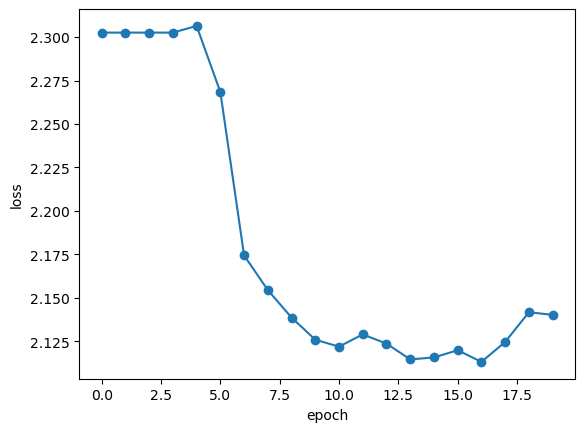

In [45]:
plt.plot(epochs, losses, '-o')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

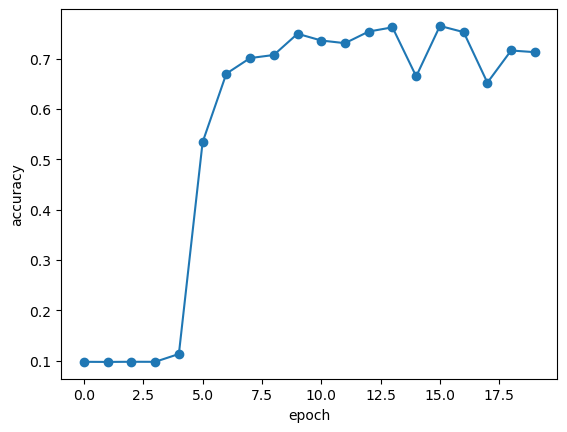

In [46]:
plt.plot(epochs, accuracies, '-o')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()